# Interpretable Machine Learning for Credit Risk Predictions

#### Import libraries 

In [2]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import numpy as np

from MOBPY.MOB import MOB
from MOBPY.plot.MOB_PLOT import MOB_PLOT
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#### Set seed to ensure reproducibility

In [3]:
seed = 31122024

## Import Data and create training and testing datasets

In [4]:
credit_data = pd.read_csv('Data/cs-training.csv', index_col=0)

In [5]:
credit_data.describe().T

count         mean           std  \
SeriousDlqin2yrs                      150000.0     0.066840      0.249746   
RevolvingUtilizationOfUnsecuredLines  150000.0     6.048438    249.755371   
age                                   150000.0    52.295207     14.771866   
NumberOfTime30-59DaysPastDueNotWorse  150000.0     0.421033      4.192781   
DebtRatio                             150000.0   353.005076   2037.818523   
MonthlyIncome                         120269.0  6670.221237  14384.674215   
NumberOfOpenCreditLinesAndLoans       150000.0     8.452760      5.145951   
NumberOfTimes90DaysLate               150000.0     0.265973      4.169304   
NumberRealEstateLoansOrLines          150000.0     1.018240      1.129771   
NumberOfTime60-89DaysPastDueNotWorse  150000.0     0.240387      4.155179   
NumberOfDependents                    146076.0     0.757222      1.115086   

                                      min          25%          50%  \
SeriousDlqin2yrs                      0.0     0.000000     0.000000   
RevolvingUtilizationOfUnsecuredLines  0.0     0.029867     0.154181   
age                                   0.0    41.000000    52.000000   
NumberOfTime30-59DaysPastDueNotWorse  0.0     0.000000     0.000000   
DebtRatio                             0.0     0.175074     0.366508   
MonthlyIncome                         0.0  3400.000000  5400.000000   
NumberOfOpenCreditLinesAndLoans       0.0     5.000000     8.000000   
NumberOfTimes90DaysLate               0.0     0.000000     0.000000   
NumberRealEstateLoansOrLines          0.0     0.000000     1.000000   
NumberOfTime60-89DaysPastDueNotWorse  0.0     0.000000     0.000000   
NumberOfDependents                    0.0     0.000000     0.000000   

                                              75%        max  
SeriousDlqin2yrs                         0.000000        1.0  
RevolvingUtilizationOfUnsecuredLines     0.559046    50708.0  
age                                     63.000000      109.0  
NumberOfTime30-59DaysPastDueNotWorse     0.000000       98.0  
DebtRatio                                0.868254   329664.0  
MonthlyIncome                         8249.000000  3008750.0  
NumberOfOpenCreditLinesAndLoans         11.000000       58.0  
NumberOfTimes90DaysLate                  0.000000       98.0  
NumberRealEstateLoansOrLines             2.000000       54.0  
NumberOfTime60-89DaysPastDueNotWorse     0.000000       98.0  
NumberOfDependents                       1.000000       20.0

#### Print the proportions and absolute amounts for delinqunet and non-delinquent observations in the dataset

In [6]:
print('No Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts()[0]/len(credit_data) * 100,2), '% of the dataset')
print('Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts()[1]/len(credit_data) * 100,2), '% of the dataset')
print('/n')
print('No Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts(),2))
print('Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts(),2))


No Serious Delinquencies 93.32 % of the dataset
Serious Delinquencies 6.68 % of the dataset
/n
No Serious Delinquencies 0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64
Serious Delinquencies 0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64


#### Visualize these proportions using a bar chart

Text(0.5, 1.0, 'Class Distributions \n (0: No Serious Delinquencies || 1: Serious Delinquencies)')

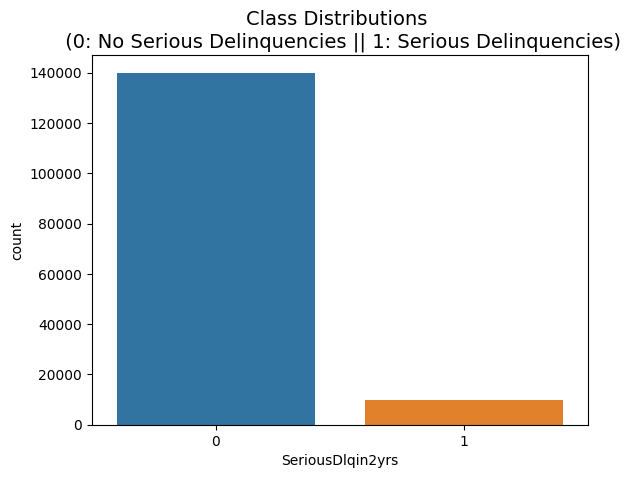

In [7]:
sns.countplot(x='SeriousDlqin2yrs', data=credit_data)
plt.title('Class Distributions \n (0: No Serious Delinquencies || 1: Serious Delinquencies)', fontsize=14)

In [8]:
def remove_outliers_iqr(df, column):
    """
    Removes outliers from a given column of a DataFrame using the Interquartile Range (IQR) method.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    column (str): The column name for which outliers should be removed.
    
    Returns:
    DataFrame: A DataFrame with outliers removed for the specified column.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range (IQR)
    
    # Define lower and upper bounds for outliers 
    lower_bound = Q1 - 5 * IQR  
    upper_bound = Q3 + 5 * IQR  
    
    # Return the DataFrame with values within the defined bounds
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]  

# Store initial dataset statistics before removing outliers
initial_rows = credit_data.shape[0]  # Total number of rows before outlier removal
initial_serious_dlq = credit_data[credit_data['SeriousDlqin2yrs'] == 1].shape[0]  # Count of rows where SeriousDlqin2yrs = 1

# Select only numeric columns for outlier removal
numeric_columns = credit_data.select_dtypes(include=['number']).columns  

# Exclude the target variable ('SeriousDlqin2yrs') from outlier removal
numeric_columns = numeric_columns[numeric_columns != 'SeriousDlqin2yrs']  

# Further filter numeric columns to include only those with values >= 1000 
numeric_columns = [col for col in numeric_columns if credit_data[col].max() >= 1000]  

# Manually add 'NumberRealEstateLoansOrLines' to the list of columns for outlier removal
numeric_columns.append("NumberRealEstateLoansOrLines")  

# Iterate through selected columns and remove outliers
for col in numeric_columns:
    credit_data = remove_outliers_iqr(credit_data, col)

# Store final dataset statistics after removing outliers
final_rows = credit_data.shape[0]  # Total number of rows after outlier removal
final_serious_dlq = credit_data[credit_data['SeriousDlqin2yrs'] == 1].shape[0]  # Count of rows where SeriousDlqin2yrs = 1 after removal

# Print the number of removed rows
print(f"Total rows removed: {initial_rows - final_rows}")
print(f"Rows with SeriousDlqin2yrs = 1 removed: {initial_serious_dlq - final_serious_dlq}")

# Display the modified dataset
display(credit_data)


Total rows removed: 33096
Rows with SeriousDlqin2yrs = 1 removed: 1846


SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                      1                              0.766127   45   
2                      0                              0.957151   40   
3                      0                              0.658180   38   
4                      0                              0.233810   30   
6                      0                              0.213179   74   
...                  ...                                   ...  ...   
149995                 0                              0.385742   50   
149996                 0                              0.040674   74   
149997                 0                              0.299745   44   
149999                 0                              0.000000   30   
150000                 0                              0.850283   64   

        NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                          2   0.802982         9120.0   
2                                          0   0.121876         2600.0   
3                                          1   0.085113         3042.0   
4                                          0   0.036050         3300.0   
6                                          0   0.375607         3500.0   
...                                      ...        ...            ...   
149995                                     0   0.404293         3400.0   
149996                                     0   0.225131         2100.0   
149997                                     0   0.716562         5584.0   
149999                                     0   0.000000         5716.0   
150000                                     0   0.249908         8158.0   

        NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                                    13                        0   
2                                     4                        0   
3                                     2                        1   
4                                     5                        0   
6                                     3                        0   
...                                 ...                      ...   
149995                                7                        0   
149996                                4                        0   
149997                                4                        0   
149999                                4                        0   
150000                                8                        0   

        NumberRealEstateLoansOrLines  NumberOfTime60-89DaysPastDueNotWorse  \
1                                  6                                     0   
2                                  0                                     0   
3                                  0                                     0   
4                                  0                                     0   
6                                  1                                     0   
...                              ...                                   ...   
149995                             0                                     0   
149996                             1                                     0   
149997                             1                                     0   
149999                             0                                     0   
150000                             2                                     0   

        NumberOfDependents  
1                      2.0  
2                      1.0  
3                      0.0  
4                      0.0  
6                      1.0  
...                    ...  
149995                 0.0  
149996                 0.0  
149997                 2.0  
149999                 0.0  
150000                 0.0  

[116904 rows x 11 columns]

In [9]:
credit_data.describe().T

count         mean          std  min  \
SeriousDlqin2yrs                      116904.0     0.069972     0.255101  0.0   
RevolvingUtilizationOfUnsecuredLines  116904.0     0.333224     0.356602  0.0   
age                                   116904.0    51.326028    14.422608  0.0   
NumberOfTime30-59DaysPastDueNotWorse  116904.0     0.385915     3.547178  0.0   
DebtRatio                             116904.0     0.358832     0.357908  0.0   
MonthlyIncome                         116904.0  6369.786132  4139.669525  0.0   
NumberOfOpenCreditLinesAndLoans       116904.0     8.754756     5.148024  0.0   
NumberOfTimes90DaysLate               116904.0     0.215998     3.513858  0.0   
NumberRealEstateLoansOrLines          116904.0     1.044686     1.085258  0.0   
NumberOfTime60-89DaysPastDueNotWorse  116904.0     0.191490     3.496476  0.0   
NumberOfDependents                    116904.0     0.849081     1.144812  0.0   

                                              25%          50%          75%  \
SeriousDlqin2yrs                         0.000000     0.000000     0.000000   
RevolvingUtilizationOfUnsecuredLines     0.035096     0.177480     0.578219   
age                                     41.000000    51.000000    61.000000   
NumberOfTime30-59DaysPastDueNotWorse     0.000000     0.000000     0.000000   
DebtRatio                                0.141433     0.291293     0.468653   
MonthlyIncome                         3500.000000  5427.500000  8249.000000   
NumberOfOpenCreditLinesAndLoans          5.000000     8.000000    11.000000   
NumberOfTimes90DaysLate                  0.000000     0.000000     0.000000   
NumberRealEstateLoansOrLines             0.000000     1.000000     2.000000   
NumberOfTime60-89DaysPastDueNotWorse     0.000000     0.000000     0.000000   
NumberOfDependents                       0.000000     0.000000     2.000000   

                                               max  
SeriousDlqin2yrs                          1.000000  
RevolvingUtilizationOfUnsecuredLines      3.126246  
age                                     103.000000  
NumberOfTime30-59DaysPastDueNotWorse     98.000000  
DebtRatio                                 4.309568  
MonthlyIncome                         32366.000000  
NumberOfOpenCreditLinesAndLoans          57.000000  
NumberOfTimes90DaysLate                  98.000000  
NumberRealEstateLoansOrLines             12.000000  
NumberOfTime60-89DaysPastDueNotWorse     98.000000  
NumberOfDependents                       20.000000

In [11]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116904 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      116904 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  116904 non-null  float64
 2   age                                   116904 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  116904 non-null  int64  
 4   DebtRatio                             116904 non-null  float64
 5   MonthlyIncome                         116904 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       116904 non-null  int64  
 7   NumberOfTimes90DaysLate               116904 non-null  int64  
 8   NumberRealEstateLoansOrLines          116904 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  116904 non-null  int64  
 10  NumberOfDependents                    116904 non-null  float64
dtype

In [12]:
credit_data['SeriousDlqin2yrs'].value_counts()

0    108724
1      8180
Name: SeriousDlqin2yrs, dtype: int64

In [13]:
print('No Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts()[0]/len(credit_data) * 100,2), '% of the dataset')
print('Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts()[1]/len(credit_data) * 100,2), '% of the dataset')

print('No Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts(),2))
print('Serious Delinquencies', round(credit_data['SeriousDlqin2yrs'].value_counts(),2))


No Serious Delinquencies 93.0 % of the dataset
Serious Delinquencies 7.0 % of the dataset
No Serious Delinquencies 0    108724
1      8180
Name: SeriousDlqin2yrs, dtype: int64
Serious Delinquencies 0    108724
1      8180
Name: SeriousDlqin2yrs, dtype: int64


Text(0.5, 1.0, 'Class Distributions \n (0: No Serious Delinquencies || 1: Serious Delinquencies)')

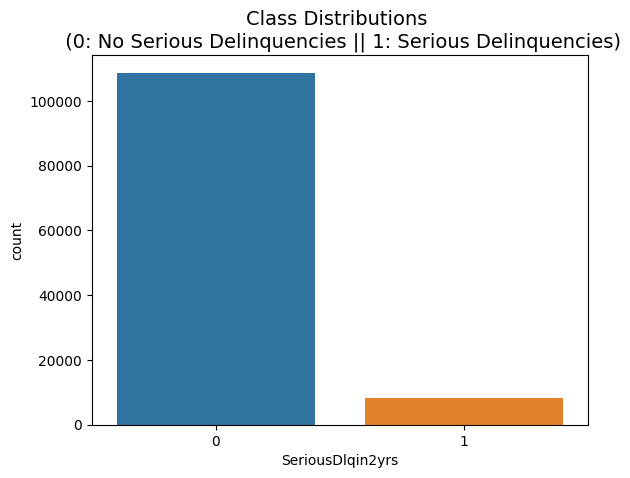

In [14]:
sns.countplot(x='SeriousDlqin2yrs', data=credit_data)
plt.title('Class Distributions \n (0: No Serious Delinquencies || 1: Serious Delinquencies)', fontsize=14)

In [15]:
credit_data.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

## Exploratory Data Analysis

#### Correlation matrix

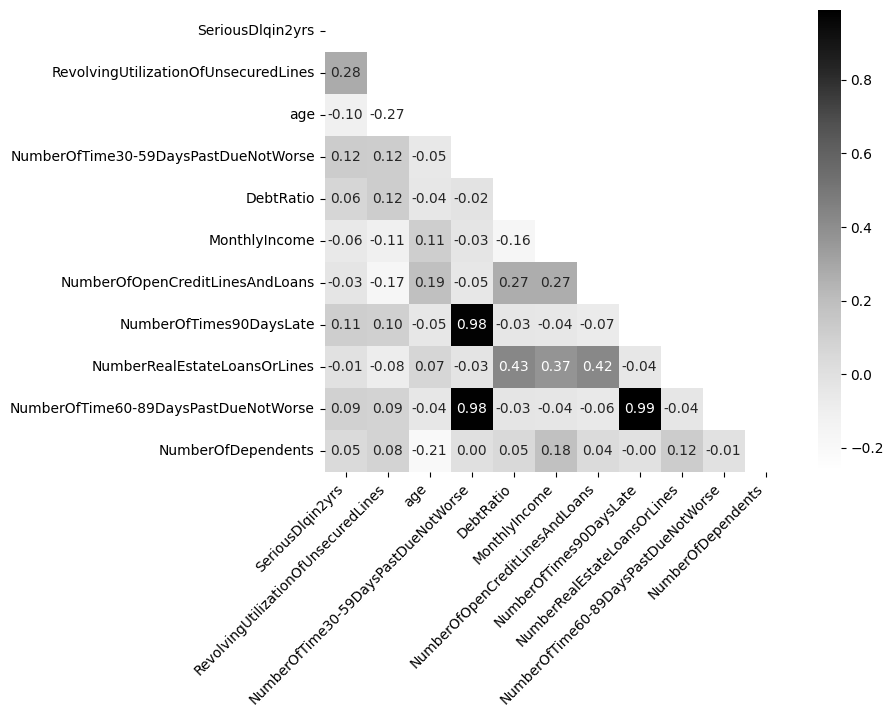

In [16]:
corr = credit_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap="Greys", fmt=".2f", cbar=True, square=True)
plt.xticks(rotation=45, ha='right') 
plt.show()

In [ ]:
credit_data.fillna(0, inplace=True)

### Calculate variance inflation factors for each variable. 

In [19]:
X = credit_data.drop(columns=['SeriousDlqin2yrs'])
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif_data)

                                feature        VIF
0  RevolvingUtilizationOfUnsecuredLines   1.852792
1                                   age   5.404316
2  NumberOfTime30-59DaysPastDueNotWorse  28.354762
3                             DebtRatio   2.971023
4                         MonthlyIncome   4.684621
5       NumberOfOpenCreditLinesAndLoans   5.184607
6               NumberOfTimes90DaysLate  51.033585
7          NumberRealEstateLoansOrLines   3.281266
8  NumberOfTime60-89DaysPastDueNotWorse  63.934882
9                    NumberOfDependents   1.617341


### Drop NumberOfTimes90DaysLate and NumberOfTime60-89DaysPastDueNotWorse variables since these are highly correlated with NumberOfTime30-59DaysPastDueNotWorse.

In [20]:
credit_data = credit_data.drop(columns=['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate'])

In [21]:
sampled_data = credit_data.sample(n=1000, random_state=42)

<Figure size 1500x1000 with 0 Axes>

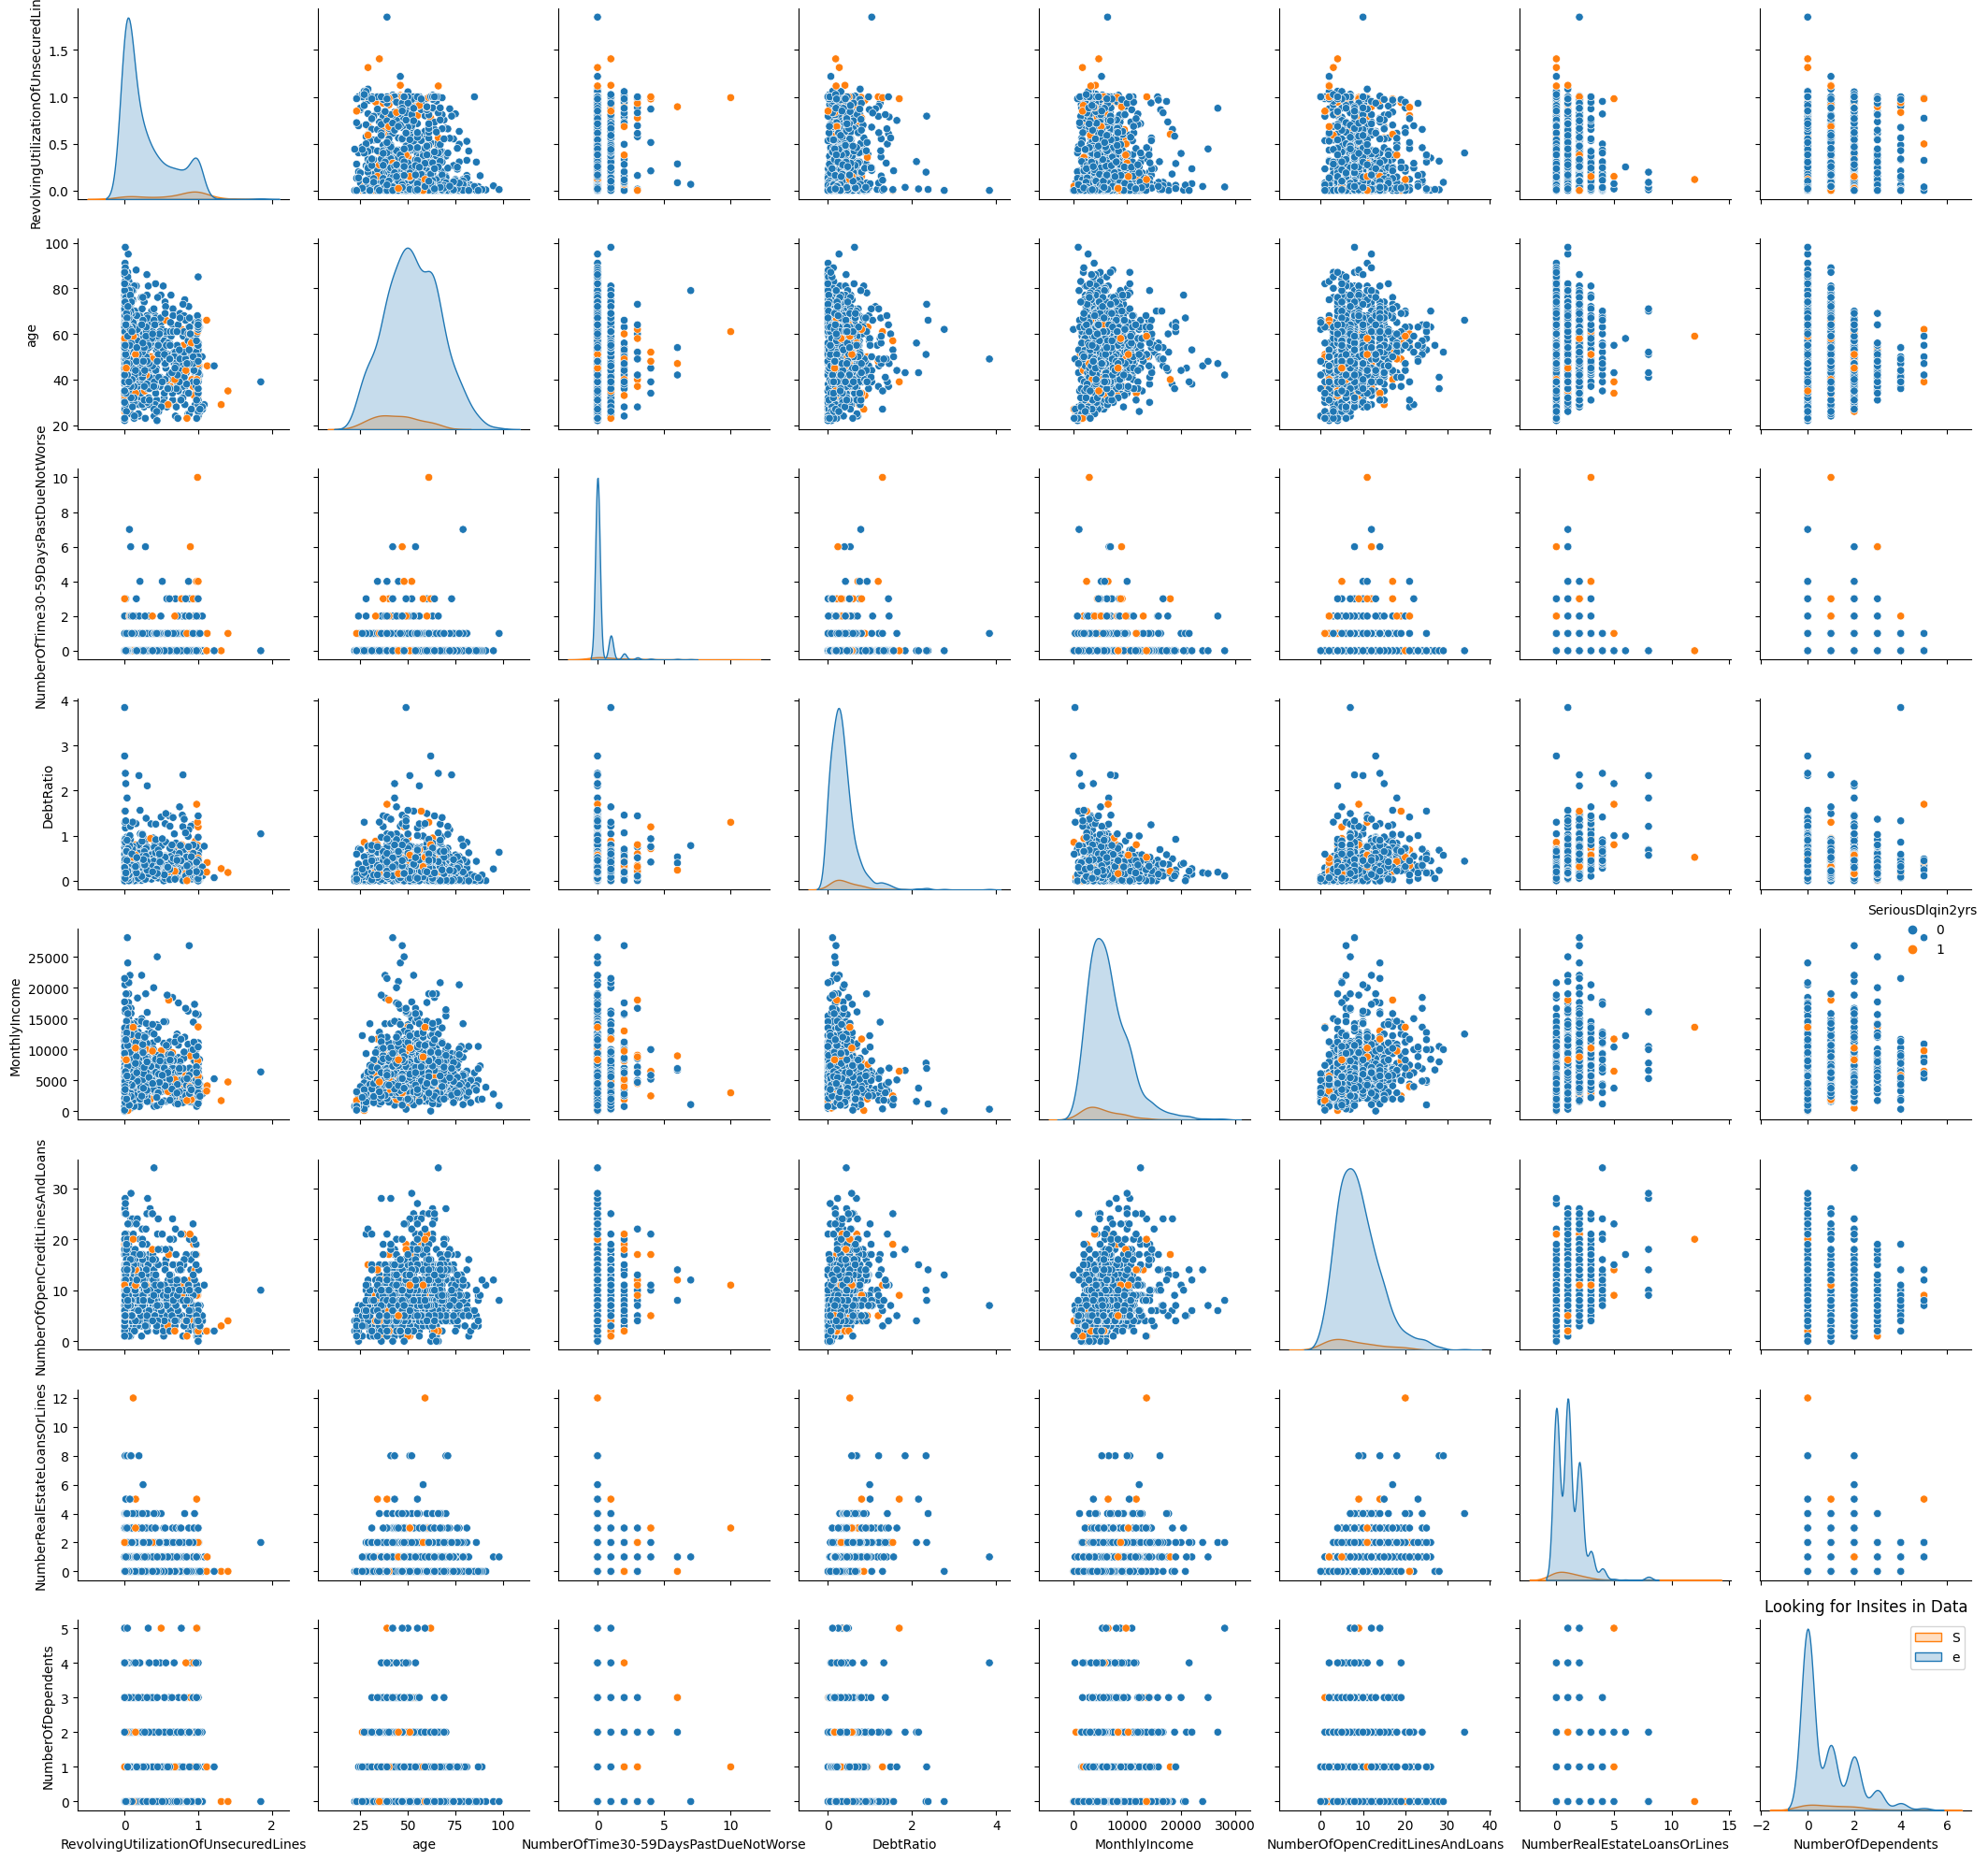

In [22]:
plt.figure(figsize=(15,10))
sns.pairplot(sampled_data,hue="SeriousDlqin2yrs")
plt.title("Looking for Insites in Data")
plt.tight_layout()
plt.legend("SeriousDlqin2yrs")



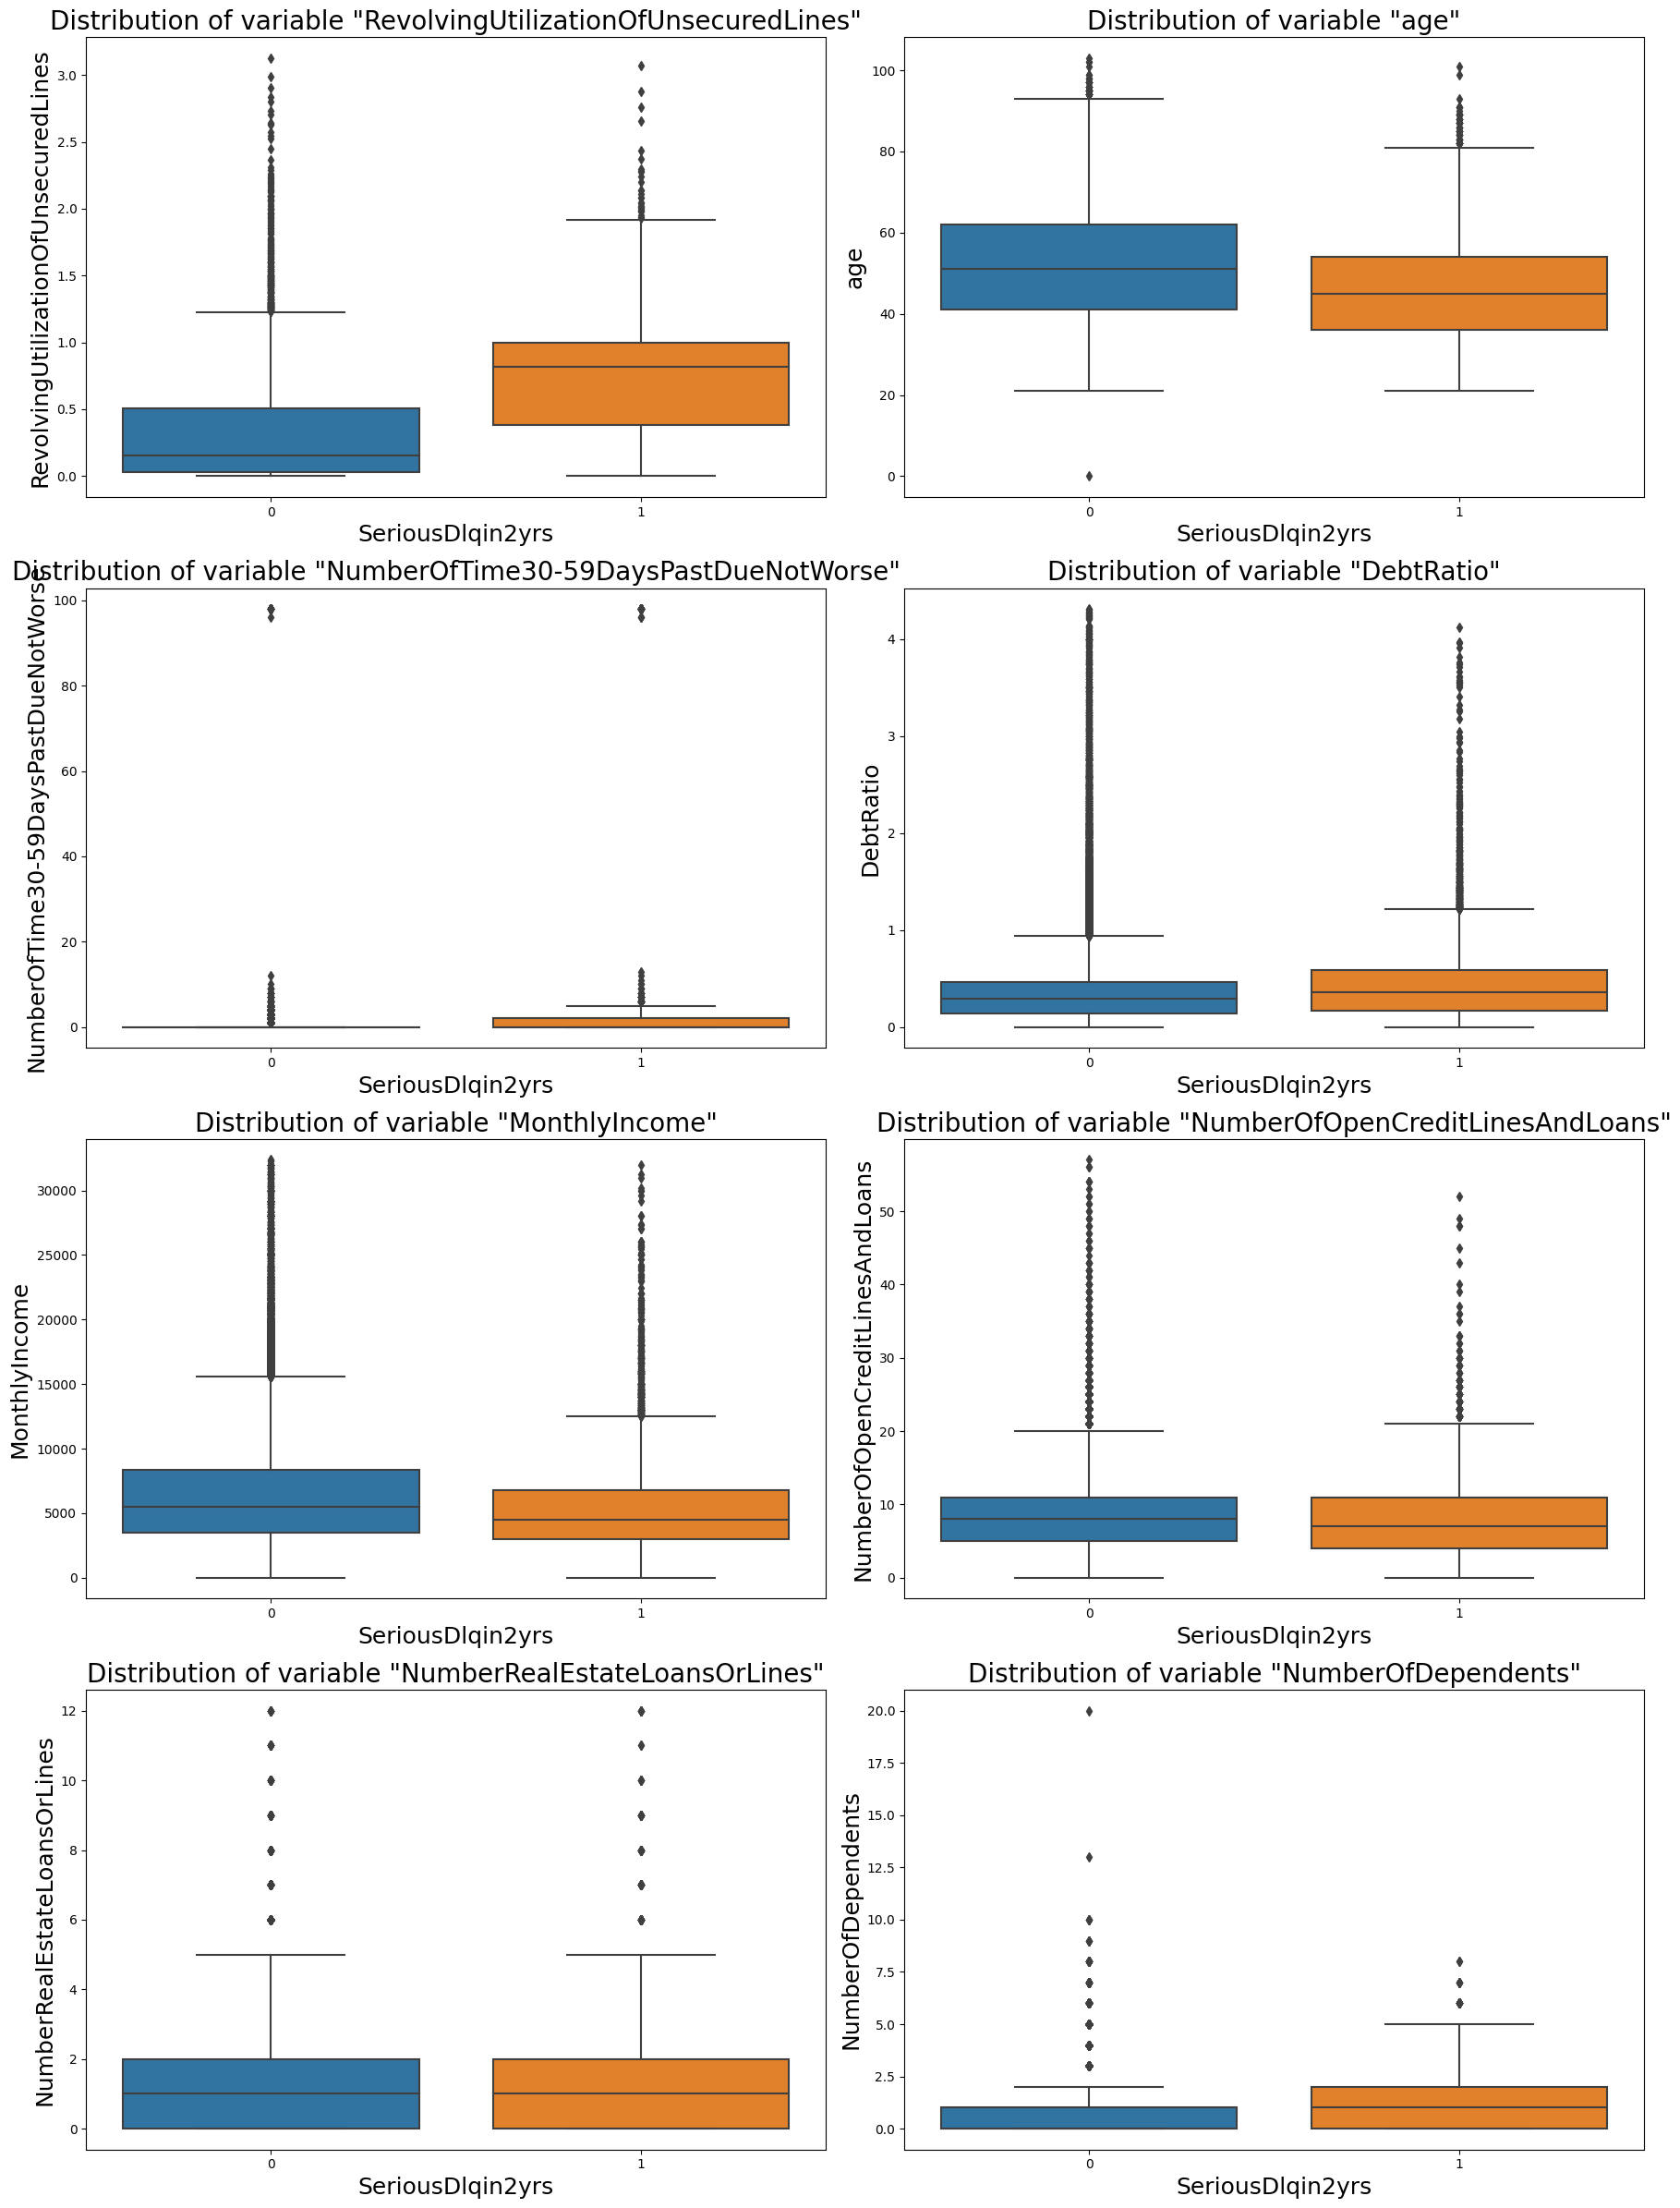

In [23]:

# Exclude the 'SeriousDlqin2yrs' column from the list of columns to plot
columns_to_plot = [col for col in credit_data.columns if col != "SeriousDlqin2yrs"]

# Define the number of columns and rows for the subplot grid
n_cols = 2  # Number of columns in the grid
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot each column in a subplot
for i, col in enumerate(columns_to_plot):
    sns.boxplot(data=credit_data, x="SeriousDlqin2yrs", y=col, ax=axes[i])
    axes[i].set_title(f'Distribution of variable "{col}"', fontsize=20)  # Increase title font size
    axes[i].set_xlabel("SeriousDlqin2yrs", fontsize=18)  # Increase x-axis label font size
    axes[i].set_ylabel(col, fontsize=18)  # Increase y-axis label font size
    axes[i].tick_params(axis='both', labelsize=10)  # Increase tick label font size

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('Plots/all_boxplots_combined.png', dpi=500)
plt.show()
plt.close()

In [24]:
credit_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'NumberOfDependents'],
      dtype='object')

### Data Preprocessing

In [25]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116904 entries, 1 to 150000
Data columns (total 9 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      116904 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  116904 non-null  float64
 2   age                                   116904 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  116904 non-null  int64  
 4   DebtRatio                             116904 non-null  float64
 5   MonthlyIncome                         116904 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       116904 non-null  int64  
 7   NumberRealEstateLoansOrLines          116904 non-null  int64  
 8   NumberOfDependents                    116904 non-null  float64
dtypes: float64(4), int64(5)
memory usage: 8.9 MB


In [26]:
credit_data.isnull().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberRealEstateLoansOrLines            0
NumberOfDependents                      0
dtype: int64

In [27]:
credit_data[credit_data['MonthlyIncome'].isnull()]['SeriousDlqin2yrs'].value_counts()

Series([], Name: SeriousDlqin2yrs, dtype: int64)

### Monotone optimal binning

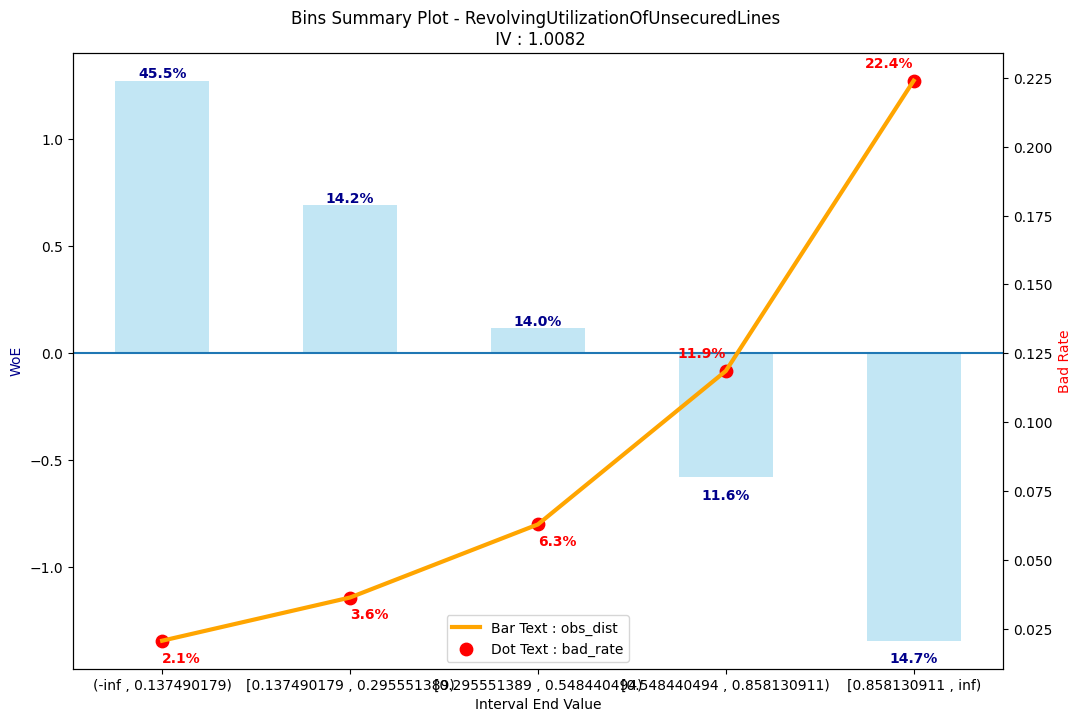

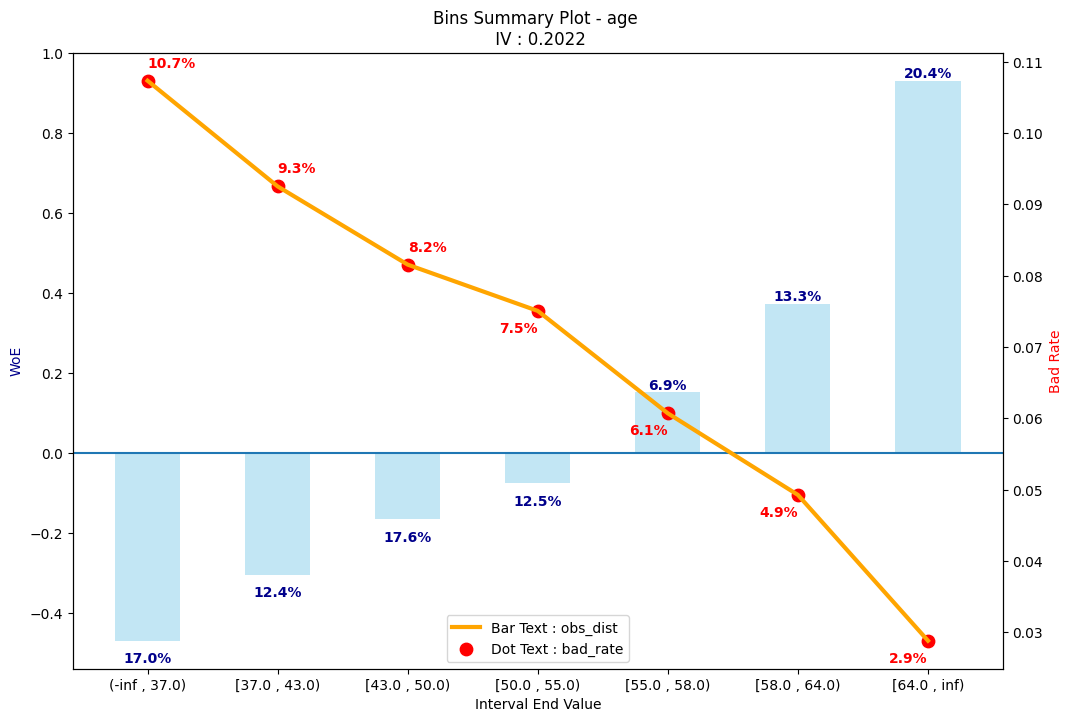

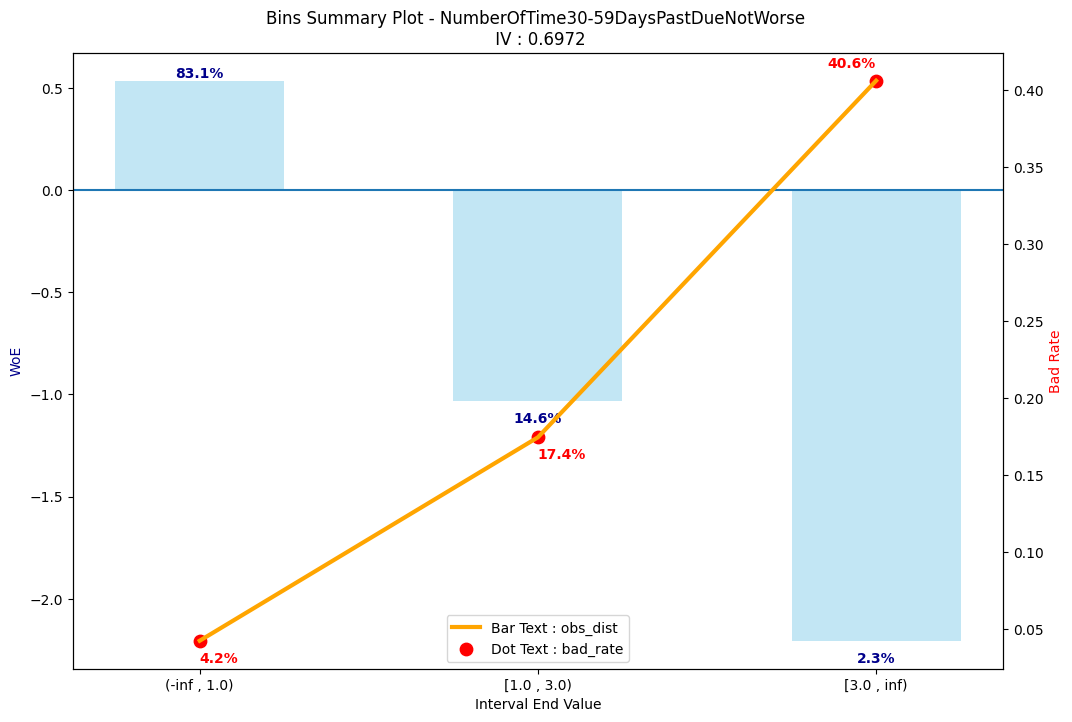

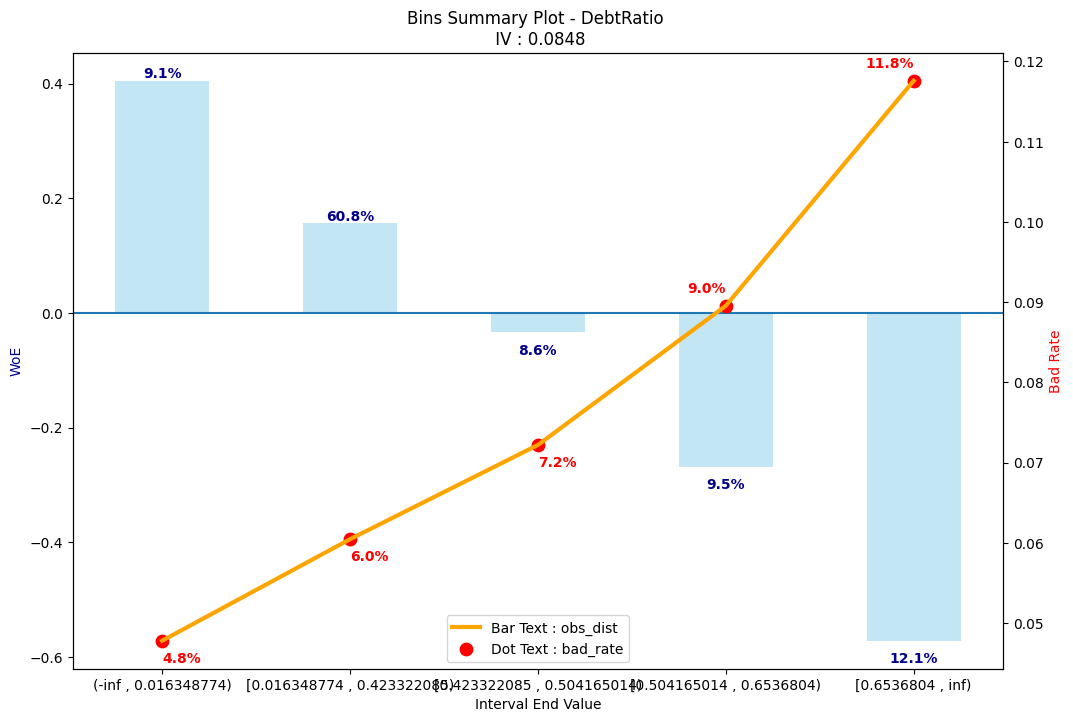

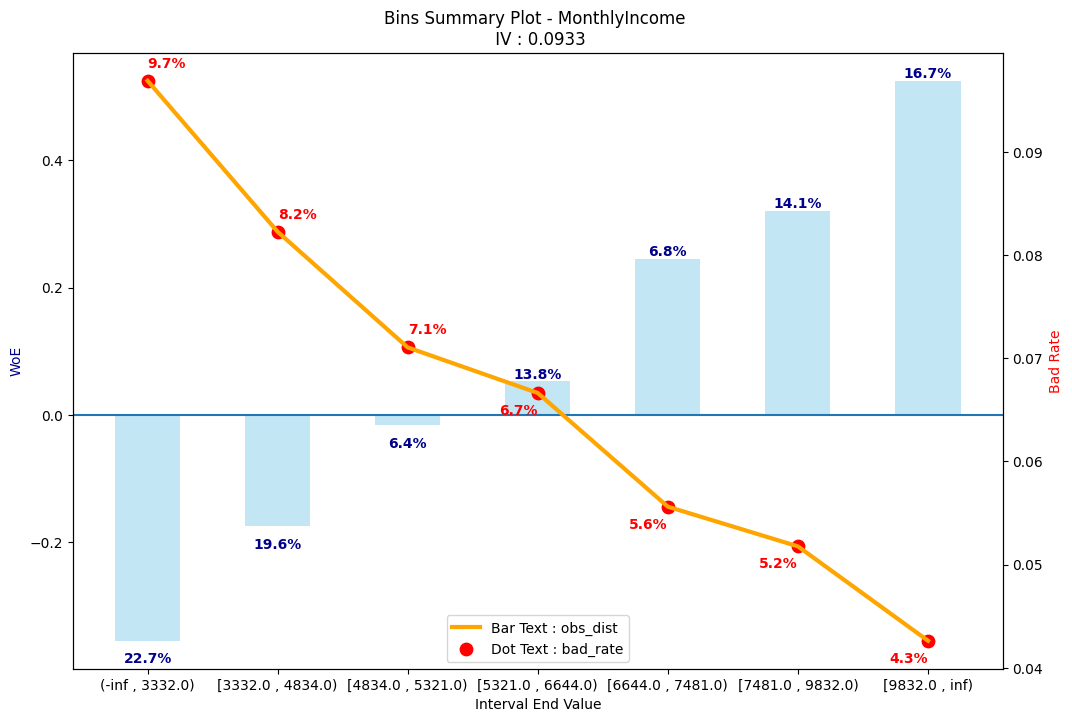

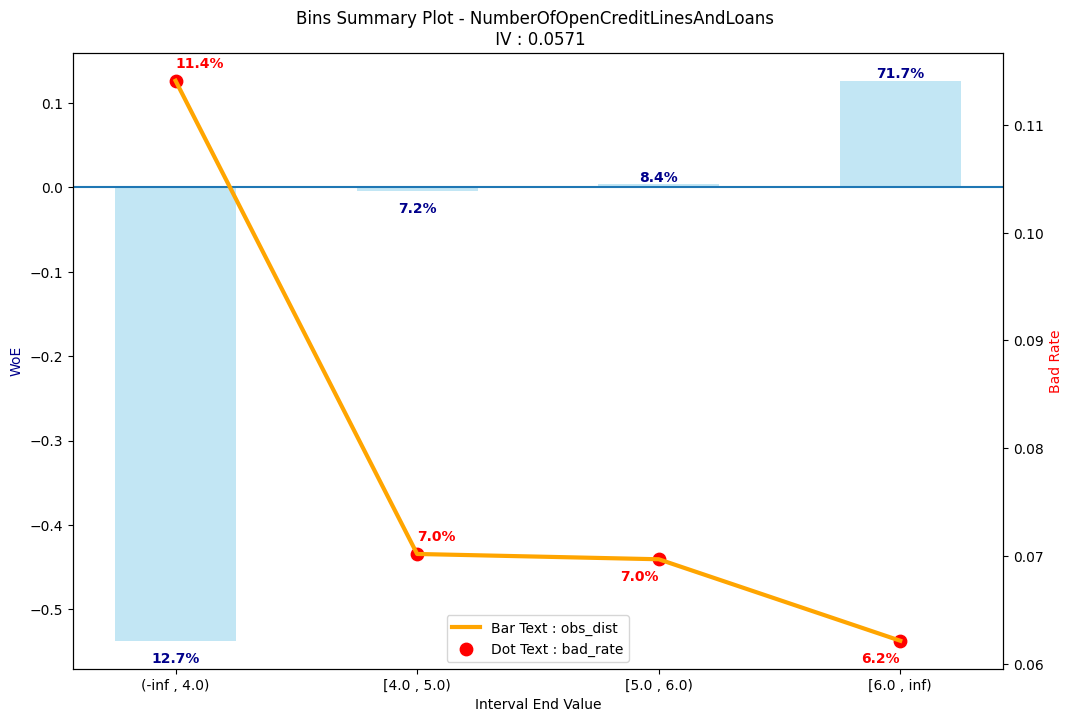

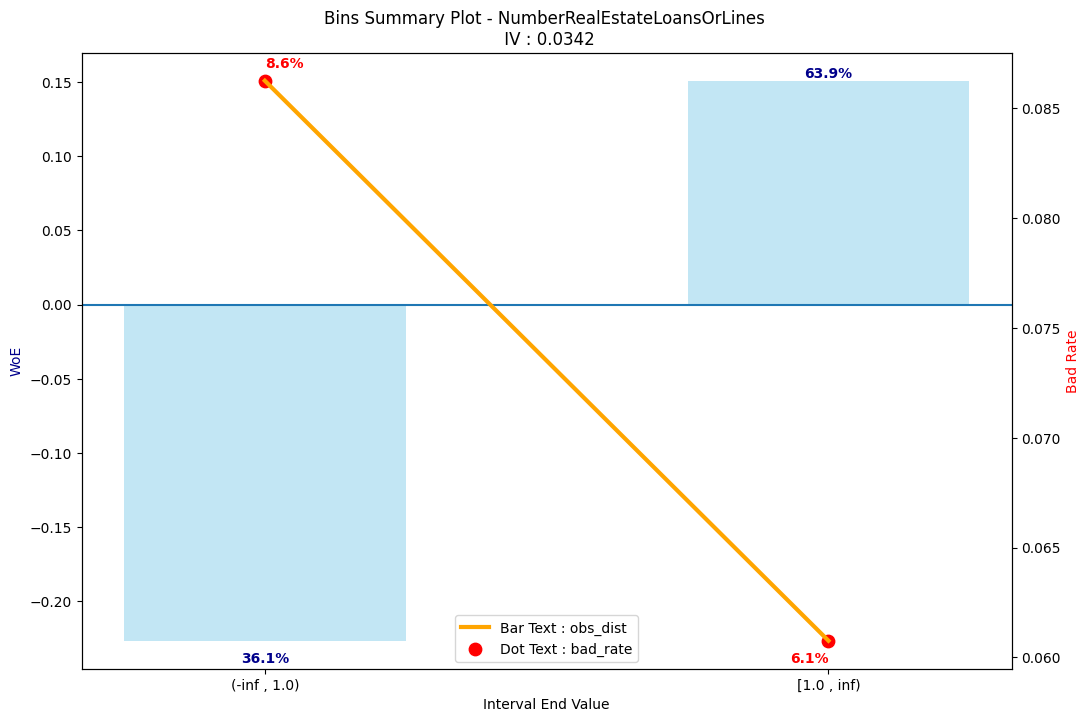

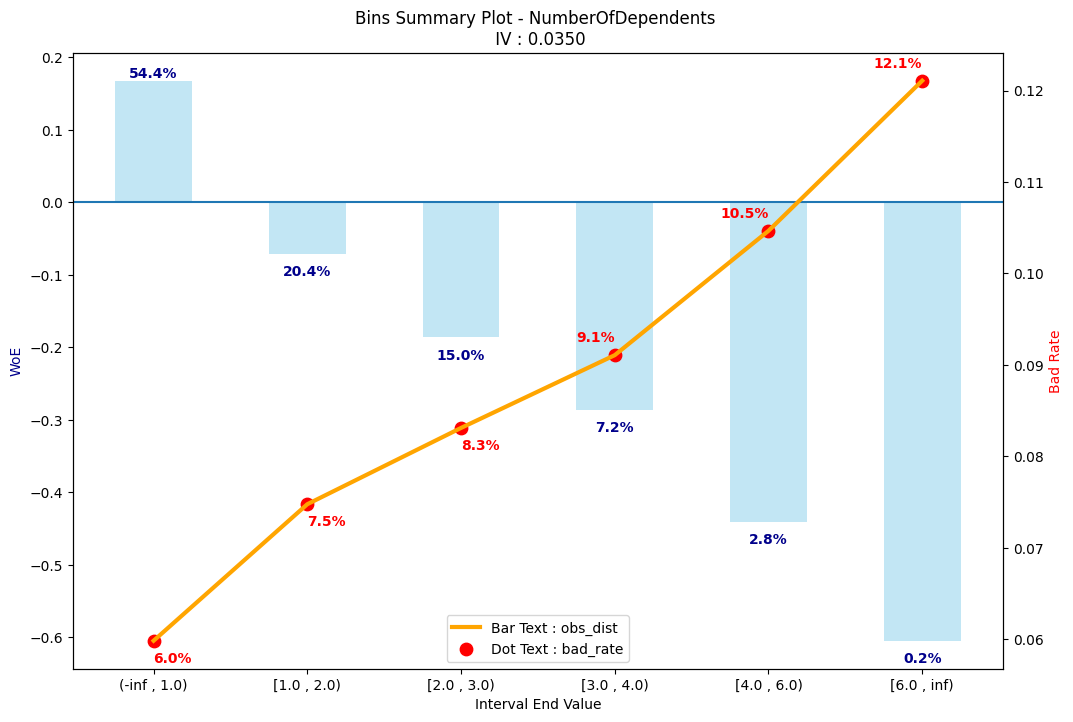

In [30]:
results = {}

# Define the parameters for the binning constraints
binning_constraints = {
    "max_bins" : 7, 
    "min_bins" : 3, 
    "max_samples" : 0.5,
    "min_bads" : 0.05,
    "min_samples" : 0.05,
    "init_pvalue" : 0.2, 
    "maximize_bins" : True
}

# Loop through all variables in the DataFrame (excluding the response variable)
response_variable = 'SeriousDlqin2yrs'
for var in credit_data.columns:
    if var != response_variable:  # Exclude the response variable
        try:
            # Initialize the MOB algorithm for the variable
            MOB_ALGO = MOB(data=credit_data, var=var, response=response_variable, exclude_value=None)
            
            # Set the binning constraints
            MOB_ALGO.setBinningConstraints(**binning_constraints)
            
            stats_binning = MOB_ALGO.runMOB(mergeMethod='Size')
            
            # Store the results in the dictionary
            results[var] = {
                'StatsBinning': stats_binning
            }
        
        except Exception as e:
            print(f"Error processing variable {var}: {e}")

# Access results for each variable
for var, bins in results.items():
    MOB_PLOT.plotBinsSummary(monoOptBinTable = bins['StatsBinning'], figsavePath = f"Plots/{var}")
    bins['StatsBinning']['Category'] = bins['StatsBinning'].apply(lambda row: f"[{row['[intervalStart']}, {row['intervalEnd)']})", axis=1)

    print()

In [31]:
data = {}
for var, binning_info in results.items():
    categories = binning_info['StatsBinning']['Category']
    data[var] = categories

# Convert the data into a pandas DataFrame
df = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})

# Display the DataFrame using tabulate for a nicer format
print(tabulate(df, headers='keys', tablefmt='latex', showindex=False))

\begin{tabular}{llllllll}
\hline
 RevolvingUtilizationOfUnsecuredLines   & age          & NumberOfTime30-59DaysPastDueNotWorse   & DebtRatio                  & MonthlyIncome    & NumberOfOpenCreditLinesAndLoans   & NumberRealEstateLoansOrLines   & NumberOfDependents   \\
\hline
 [-inf, 0.137490179)                    & [-inf, 37.0) & [-inf, 1.0)                            & [-inf, 0.016348774)        & [-inf, 3332.0)   & [-inf, 4.0)                       & [-inf, 1.0)                    & [-inf, 1.0)          \\
 [0.137490179, 0.295551389)             & [37.0, 43.0) & [1.0, 3.0)                             & [0.016348774, 0.423322085) & [3332.0, 4834.0) & [4.0, 5.0)                        & [1.0, inf)                     & [1.0, 2.0)           \\
 [0.295551389, 0.548440494)             & [43.0, 50.0) & [3.0, inf)                             & [0.423322085, 0.504165014) & [4834.0, 5321.0) & [5.0, 6.0)                        & nan                            & [2.0, 3.0)           \\
 [0.

In [33]:
binned_data = credit_data.copy()

# Loop through each variable in the results dictionary
for var, binning_info in results.items():
    # Extract the binning rules for the current variable
    stats_binning = binning_info['StatsBinning']
    
    # Extract the bin edges and labels from the binning rules
    bin_edges = stats_binning['[intervalStart'].tolist() + [stats_binning['intervalEnd)'].iloc[-1]]  # This should be a list of bin edges
    bin_edges = [float(x) if isinstance(x, str) else x for x in bin_edges]
    
    # Replace 'inf' and '-inf' with np.inf and -np.inf
    bin_edges = [np.inf if x == 'inf' else -np.inf if x == '-inf' else x for x in bin_edges]
    bin_labels = stats_binning['Category']  # This should be a list of bin labels
    
    # Use pd.cut to map the continuous values to bins
    binned_data[f'{var}_binned'] = pd.cut(binned_data[var], bins=bin_edges, labels=bin_labels, right=False)
    
    woe_values = stats_binning['woe']
    
    # Create a mapping from bin labels to WOE values
    woe_mapping = dict(zip(bin_labels, woe_values))
    
    binned_data[f'{var}_woe'] = binned_data[f'{var}_binned'].map(woe_mapping)

# Now binned_data contains the original data along with the binned versions of the variables
display(binned_data.head())

SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
6                 0                              0.213179   74   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
6                                     0   0.375607         3500.0   

   NumberOfOpenCreditLinesAndLoans  NumberRealEstateLoansOrLines  \
1                               13                             6   
2                                4                             0   
3                                2                             0   
4                                5                             0   
6                                3                             1   

   NumberOfDependents RevolvingUtilizationOfUnsecuredLines_binned  ...  \
1                 2.0                  [0.548440494, 0.858130911)  ...   
2                 1.0                          [0.858130911, inf)  ...   
3                 0.0                  [0.548440494, 0.858130911)  ...   
4                 0.0                  [0.137490179, 0.295551389)  ...   
6                 1.0                  [0.137490179, 0.295551389)  ...   

             DebtRatio_binned DebtRatio_woe MonthlyIncome_binned  \
1            [0.6536804, inf)     -0.571776     [7481.0, 9832.0)   
2  [0.016348774, 0.423322085)      0.156578       [-inf, 3332.0)   
3  [0.016348774, 0.423322085)      0.156578       [-inf, 3332.0)   
4  [0.016348774, 0.423322085)      0.156578       [-inf, 3332.0)   
6  [0.016348774, 0.423322085)      0.156578     [3332.0, 4834.0)   

  MonthlyIncome_woe NumberOfOpenCreditLinesAndLoans_binned  \
1          0.320876                             [6.0, inf)   
2         -0.354711                             [4.0, 5.0)   
3         -0.354711                            [-inf, 4.0)   
4         -0.354711                             [5.0, 6.0)   
6         -0.174893                            [-inf, 4.0)   

  NumberOfOpenCreditLinesAndLoans_woe NumberRealEstateLoansOrLines_binned  \
1                            0.126540                          [1.0, inf)   
2                           -0.003699                         [-inf, 1.0)   
3                           -0.537353                         [-inf, 1.0)   
4                            0.003842                         [-inf, 1.0)   
6                           -0.537353                          [1.0, inf)   

  NumberRealEstateLoansOrLines_woe NumberOfDependents_binned  \
1                         0.151056                [2.0, 3.0)   
2                        -0.226872                [1.0, 2.0)   
3                        -0.226872               [-inf, 1.0)   
4                        -0.226872               [-inf, 1.0)   
6                         0.151056                [1.0, 2.0)   

  NumberOfDependents_woe  
1              -0.186170  
2              -0.071312  
3               0.167519  
4               0.167519  
6              -0.071312  

[5 rows x 25 columns]

In [34]:
binned_data.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'NumberOfDependents', 'RevolvingUtilizationOfUnsecuredLines_binned',
       'RevolvingUtilizationOfUnsecuredLines_woe', 'age_binned', 'age_woe',
       'NumberOfTime30-59DaysPastDueNotWorse_binned',
       'NumberOfTime30-59DaysPastDueNotWorse_woe', 'DebtRatio_binned',
       'DebtRatio_woe', 'MonthlyIncome_binned', 'MonthlyIncome_woe',
       'NumberOfOpenCreditLinesAndLoans_binned',
       'NumberOfOpenCreditLinesAndLoans_woe',
       'NumberRealEstateLoansOrLines_binned',
       'NumberRealEstateLoansOrLines_woe', 'NumberOfDependents_binned',
       'NumberOfDependents_woe'],
      dtype='object')

In [35]:
binned_data = binned_data[[col for col in binned_data.columns if col.endswith('_woe')]]

In [36]:
binned_data['SeriousDlqin2yrs'] = credit_data['SeriousDlqin2yrs']

## Logistic regression

In [38]:
train, test = train_test_split(binned_data, test_size=0.3,random_state=31122024)
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)
train_target = train.pop('SeriousDlqin2yrs')
test_target = test.pop('SeriousDlqin2yrs')

In [39]:
train

RevolvingUtilizationOfUnsecuredLines_woe   age_woe  \
0                                     0.690836 -0.304068   
1                                     1.272228 -0.165784   
2                                     1.272228  0.931073   
3                                     0.690836 -0.469134   
4                                     1.272228  0.373113   
...                                        ...       ...   
81827                                 1.272228 -0.304068   
81828                                 1.272228 -0.304068   
81829                                 0.114579 -0.469134   
81830                                -0.581308 -0.165784   
81831                                 1.272228  0.152076   

      NumberOfTime30-59DaysPastDueNotWorse_woe DebtRatio_woe  \
0                                     0.535299      0.156578   
1                                     0.535299      0.156578   
2                                     0.535299      0.156578   
3                                     0.535299     -0.267907   
4                                     0.535299     -0.267907   
...                                        ...           ...   
81827                                -1.031350      0.156578   
81828                                -1.031350     -0.033636   
81829                                 0.535299     -0.033636   
81830                                -1.031350     -0.571776   
81831                                 0.535299     -0.267907   

      MonthlyIncome_woe NumberOfOpenCreditLinesAndLoans_woe  \
0             -0.354711                            0.003842   
1              0.052670                            0.126540   
2              0.320876                           -0.537353   
3             -0.174893                            0.126540   
4              0.052670                            0.126540   
...                 ...                                 ...   
81827         -0.016238                           -0.537353   
81828         -0.174893                            0.126540   
81829         -0.016238                            0.126540   
81830         -0.174893                            0.126540   
81831          0.524820                            0.126540   

      NumberRealEstateLoansOrLines_woe NumberOfDependents_woe  
0                            -0.226872               0.167519  
1                             0.151056               0.167519  
2                             0.151056              -0.186170  
3                             0.151056               0.167519  
4                             0.151056               0.167519  
...                                ...                    ...  
81827                        -0.226872              -0.186170  
81828                         0.151056              -0.186170  
81829                         0.151056               0.167519  
81830                         0.151056              -0.186170  
81831                         0.151056              -0.186170  

[81832 rows x 8 columns]

### Estimate a logistic regression model

In [40]:
clf=LogisticRegression(solver='lbfgs', random_state=seed, max_iter=1000)
clf.fit(train,train_target)

LogisticRegression(max_iter=1000, random_state=31122024)

### 5-fold cross validation

In [41]:
scores = cross_validate(clf, test, test_target, scoring='roc_auc', cv=5, return_estimator=True)

In [42]:
scores['test_score'].mean()

0.8194409169824223

In [43]:
y_pred=clf.predict(test)
report = classification_report(test_target,y_pred, output_dict=True)
print(classification_report(test_target,y_pred))
report_lr = pd.DataFrame(report).transpose()
latex_table = report_lr.to_latex()
print(latex_table)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     32688
           1       0.58      0.08      0.13      2384

    accuracy                           0.93     35072
   macro avg       0.76      0.54      0.55     35072
weighted avg       0.91      0.93      0.91     35072

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &       support \\
\midrule
0            &   0.936648 &  0.995962 &  0.965395 &  32688.000000 \\
1            &   0.579618 &  0.076342 &  0.134915 &   2384.000000 \\
accuracy     &   0.933451 &  0.933451 &  0.933451 &      0.933451 \\
macro avg    &   0.758133 &  0.536152 &  0.550155 &  35072.000000 \\
weighted avg &   0.912379 &  0.933451 &  0.908943 &  35072.000000 \\
\bottomrule
\end{tabular}



C:\Users\ramie\AppData\Local\Temp\ipykernel_16388\4104701654.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = report_lr.to_latex()


#### Confusion matrises for different cut-off points. 

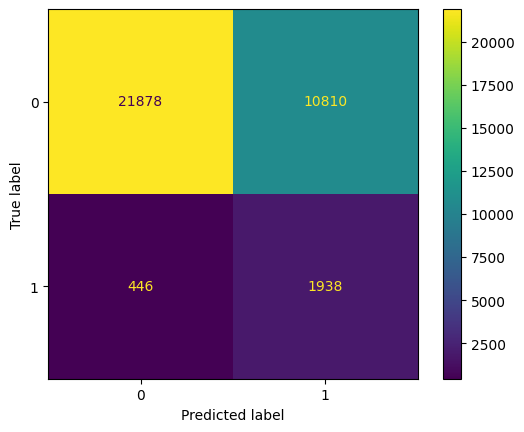

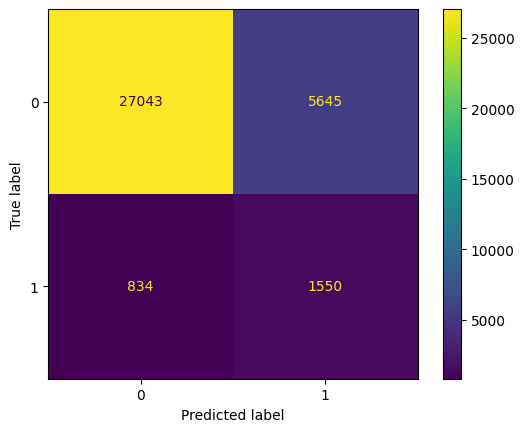

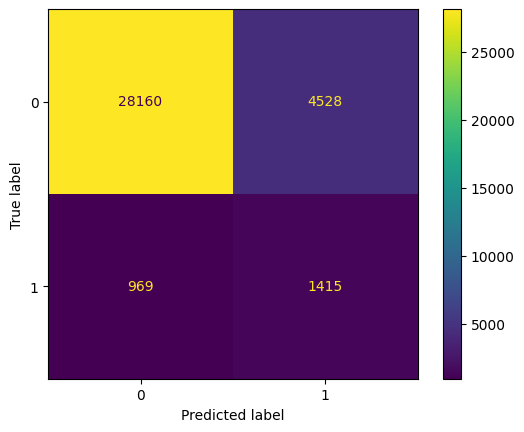

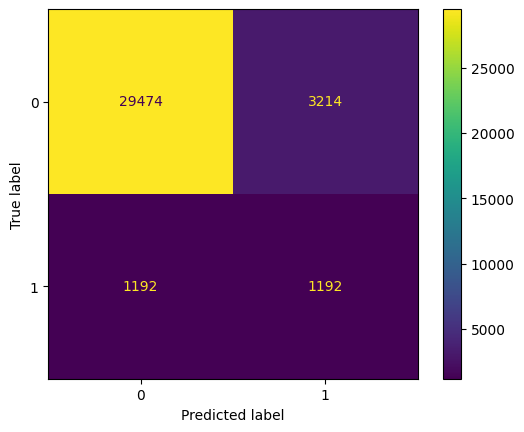

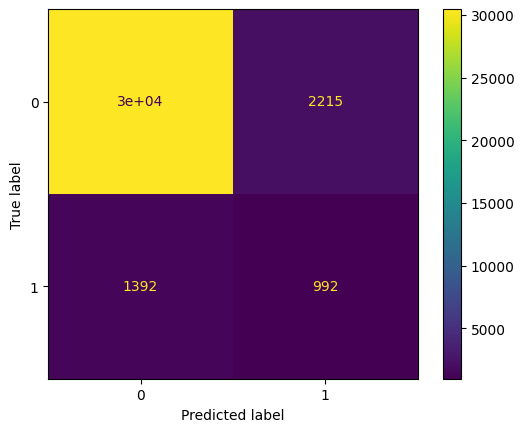

In [44]:
pred_proba = pd.DataFrame(clf.predict_proba(test))
threshold_list = [0.05,0.1,0.12,0.15,0.18]
for i in threshold_list:
    Y_test_pred = pred_proba.applymap(lambda x: 1 if x>i else 0)
    cm = confusion_matrix(test_target.values.reshape(test_target.values.size,1),
                           Y_test_pred.iloc[:,1].values.reshape(Y_test_pred.iloc[:,1].values.size,1),labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
    disp.plot()

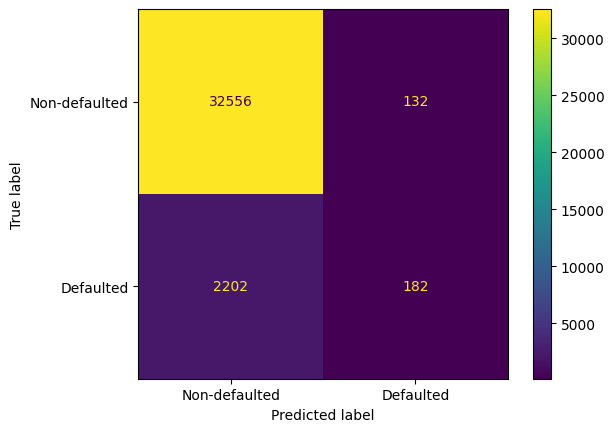

In [45]:
cm_log=confusion_matrix(test_target,y_pred,labels=[0,1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=["Non-defaulted","Defaulted"])
disp.plot()

### ROC curve

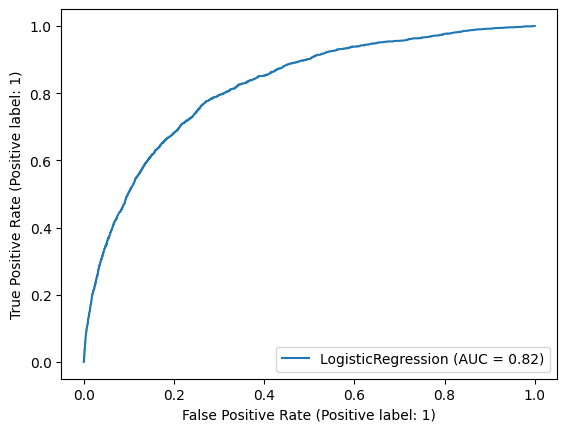

In [46]:
svc_disp = RocCurveDisplay.from_estimator(clf, test, test_target)
plt.savefig('Plots/LR_roc_curve.png')
plt.show()

### Statsmodels logistic regression, only for reference

In [47]:
est = sm.Logit(train_target, train)
est = est.fit(cov_type = 'HC1')
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.521743
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       SeriousDlqin2yrs   No. Observations:                81832
Model:                          Logit   Df Residuals:                    81824
Method:                           MLE   Df Model:                            7
Date:                Wed, 19 Feb 2025   Pseudo R-squ.:                  -1.040
Time:                        10:53:23   Log-Likelihood:                -42695.
converged:                       True   LL-Null:                       -20931.
Covariance Type:                  HC1   LLR p-value:                     1.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
RevolvingUtilizationOfUnsecuredLines_woe    -0.7

## Random Forest

#### Use full available dataset without preprocessing and binning

In [49]:
credit_data = pd.read_csv('Data/cs-training.csv', index_col=0)
credit_data.fillna(0, inplace = True)

In [50]:
train, test = train_test_split(credit_data, test_size=0.3,random_state=31122024)
train.reset_index(inplace=True, drop= True)
test.reset_index(inplace=True, drop= True)
train_target = train.pop('SeriousDlqin2yrs')
test_target = test.pop('SeriousDlqin2yrs')

In [51]:
weights = {0:1, 1:1} 

In [52]:
forest=RandomForestClassifier(n_estimators=30,random_state=seed, class_weight = weights, max_depth=9)
forest=forest.fit(train,train_target)

In [53]:
feature_names=train.columns
feature_importance_forest=pd.DataFrame(forest.feature_importances_,index=feature_names)
feature_importance_forest[0].nlargest(10)

NumberOfTimes90DaysLate                 0.317846
RevolvingUtilizationOfUnsecuredLines    0.186802
NumberOfTime60-89DaysPastDueNotWorse    0.156426
NumberOfTime30-59DaysPastDueNotWorse    0.132132
DebtRatio                               0.049781
age                                     0.048947
NumberOfOpenCreditLinesAndLoans         0.038619
MonthlyIncome                           0.038445
NumberRealEstateLoansOrLines            0.016865
NumberOfDependents                      0.014137
Name: 0, dtype: float64

In [54]:
predictions=forest.predict(test)
report_rf = classification_report(test_target, predictions, output_dict=True)
print(classification_report(y_true=test_target,y_pred=predictions,target_names=['No Serious Delinquencies','Serious Delinquencies']))
report_rf = pd.DataFrame(report_rf).transpose()
latex_table_rf = report_rf.to_latex()
print(latex_table_rf)

                          precision    recall  f1-score   support

No Serious Delinquencies       0.94      0.99      0.97     42022
   Serious Delinquencies       0.60      0.17      0.27      2978

                accuracy                           0.94     45000
               macro avg       0.77      0.58      0.62     45000
            weighted avg       0.92      0.94      0.92     45000

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &       support \\
\midrule
0            &   0.944024 &  0.992099 &  0.967465 &  42022.000000 \\
1            &   0.603819 &  0.169913 &  0.265199 &   2978.000000 \\
accuracy     &   0.937689 &  0.937689 &  0.937689 &      0.937689 \\
macro avg    &   0.773921 &  0.581006 &  0.616332 &  45000.000000 \\
weighted avg &   0.921510 &  0.937689 &  0.920991 &  45000.000000 \\
\bottomrule
\end{tabular}



C:\Users\ramie\AppData\Local\Temp\ipykernel_16388\1001780725.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_rf = report_rf.to_latex()


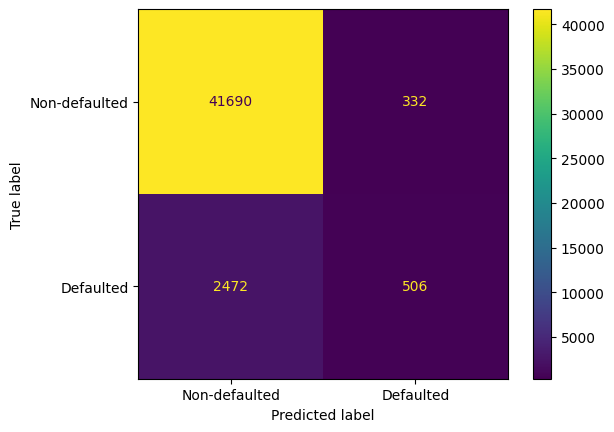

In [55]:
cm=confusion_matrix(test_target,predictions,labels=[0,1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-defaulted","Defaulted"])
disp.plot()

### Grid search

In [57]:
#, class_weight = {0:1, 1:5}
rf_grid = RandomForestClassifier(random_state=seed)
gr_space = {
    'max_depth': [6,9,12],
    'n_estimators': [20, 40, 100],
}

grid = GridSearchCV(rf_grid, gr_space, cv = 2, scoring='roc_auc', verbose = 3)
model_grid = grid.fit(train, train_target)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END ......max_depth=6, n_estimators=20;, score=0.858 total time=   0.5s
[CV 2/2] END ......max_depth=6, n_estimators=20;, score=0.860 total time=   0.5s
[CV 1/2] END ......max_depth=6, n_estimators=40;, score=0.859 total time=   1.1s
[CV 2/2] END ......max_depth=6, n_estimators=40;, score=0.860 total time=   1.2s
[CV 1/2] END .....max_depth=6, n_estimators=100;, score=0.860 total time=   3.0s
[CV 2/2] END .....max_depth=6, n_estimators=100;, score=0.861 total time=   3.0s
[CV 1/2] END ......max_depth=9, n_estimators=20;, score=0.860 total time=   0.8s
[CV 2/2] END ......max_depth=9, n_estimators=20;, score=0.862 total time=   0.7s
[CV 1/2] END ......max_depth=9, n_estimators=40;, score=0.861 total time=   1.6s
[CV 2/2] END ......max_depth=9, n_estimators=40;, score=0.862 total time=   1.6s
[CV 1/2] END .....max_depth=9, n_estimators=100;, score=0.862 total time=   4.2s
[CV 2/2] END .....max_depth=9, n_estimators=100;,

In [58]:
rf_optimized = model_grid.best_estimator_

In [59]:
predictions_rfo=rf_optimized.predict(test)
report_rfo = classification_report(test_target, predictions_rfo, output_dict=True)
print(classification_report(y_true=test_target,y_pred=predictions_rfo,target_names=['No Serious Delinquencies','Serious Delinquencies']))
report_rfo = pd.DataFrame(report_rfo).transpose()
latex_table_rfo = report_rfo.to_latex()
print(latex_table_rfo)

                          precision    recall  f1-score   support

No Serious Delinquencies       0.94      0.99      0.97     42022
   Serious Delinquencies       0.61      0.17      0.27      2978

                accuracy                           0.94     45000
               macro avg       0.78      0.58      0.62     45000
            weighted avg       0.92      0.94      0.92     45000

\begin{tabular}{lrrrr}
\toprule
{} &  precision &    recall &  f1-score &       support \\
\midrule
0            &   0.944222 &  0.992195 &  0.967614 &  42022.000000 \\
1            &   0.610913 &  0.172935 &  0.269563 &   2978.000000 \\
accuracy     &   0.937978 &  0.937978 &  0.937978 &      0.937978 \\
macro avg    &   0.777568 &  0.582565 &  0.618588 &  45000.000000 \\
weighted avg &   0.922164 &  0.937978 &  0.921418 &  45000.000000 \\
\bottomrule
\end{tabular}



C:\Users\ramie\AppData\Local\Temp\ipykernel_16388\3530997161.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table_rfo = report_rfo.to_latex()


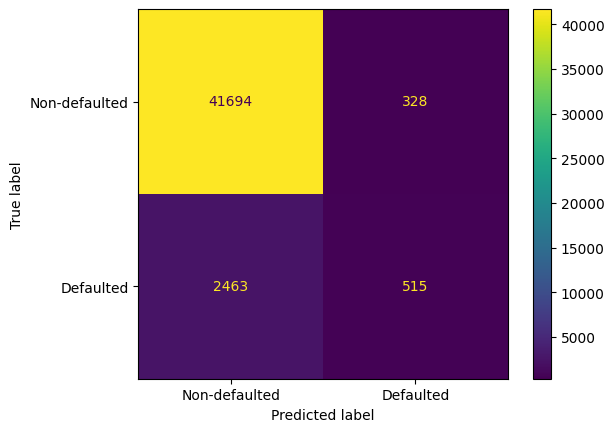

In [60]:
cm=confusion_matrix(test_target,predictions_rfo,labels=[0,1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=["Non-defaulted","Defaulted"])
disp.plot()

In [61]:
scores = cross_validate(rf_optimized, test, test_target, scoring='roc_auc', cv=5, return_estimator=True)
scores['test_score'].mean()

0.8610725785886391

### ROC curves, LR and optimized RF

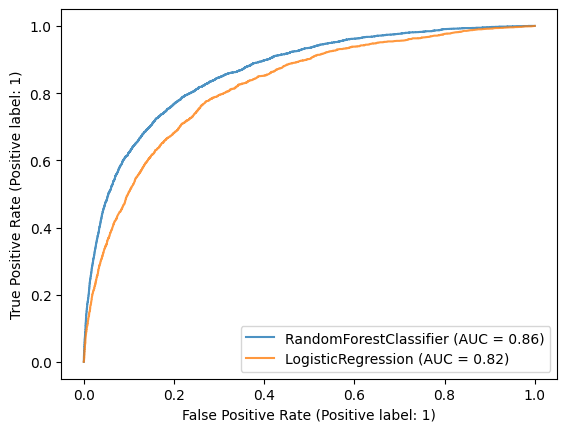

In [62]:
ax = plt.gca()
rfc_disp = RocCurveDisplay.from_estimator(rf_optimized, test, test_target, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax, alpha=0.8)
plt.savefig("Plots/auc_lr_rf.png")
plt.show()

## SHAP

In [63]:
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_optimized)

In [64]:
# Calculate SHAP values for the test set
shap_values = explainer.shap_values(train)


In [65]:
exp = explainer(train)
print(type(exp))

<class 'shap._explanation.Explanation'>


In [66]:
shap_values.shape

(105000, 10, 2)

In [67]:
# Expected/Base/Reference value = the value that would be predicted if we didn’t know any features of the current output”
print('Expected Value:', explainer.expected_value)

Expected Value: [0.93300095 0.06699905]


### SHAP summary plot

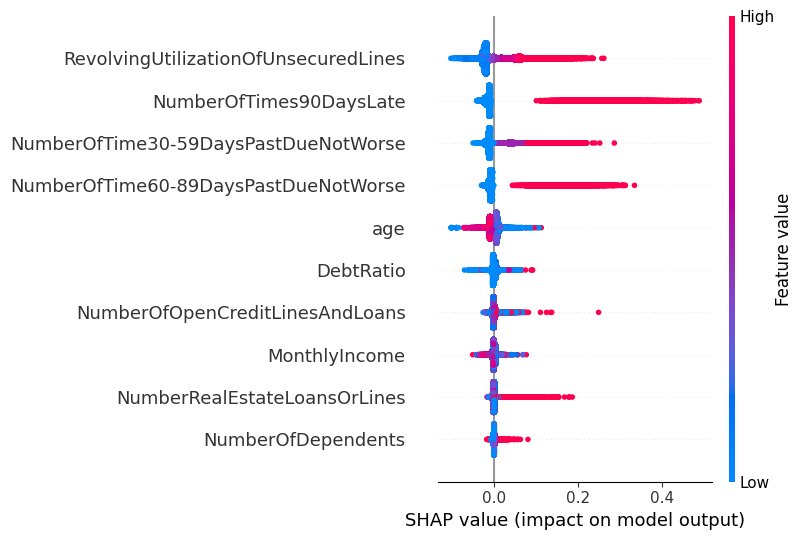

In [68]:
shap.summary_plot(shap_values[:,:,1], train,)

In [70]:
train_target[train_target==0].sample(10, random_state = seed)

86644    0
642      0
85359    0
19920    0
49693    0
32046    0
44297    0
54050    0
77538    0
96310    0
Name: SeriousDlqin2yrs, dtype: int64

In [71]:
train_target[train_target==1].sample(10, random_state = seed)

94729    1
20364    1
33010    1
4611     1
34005    1
35929    1
69016    1
19289    1
60337    1
54849    1
Name: SeriousDlqin2yrs, dtype: int64

### SHAP waterfall plots

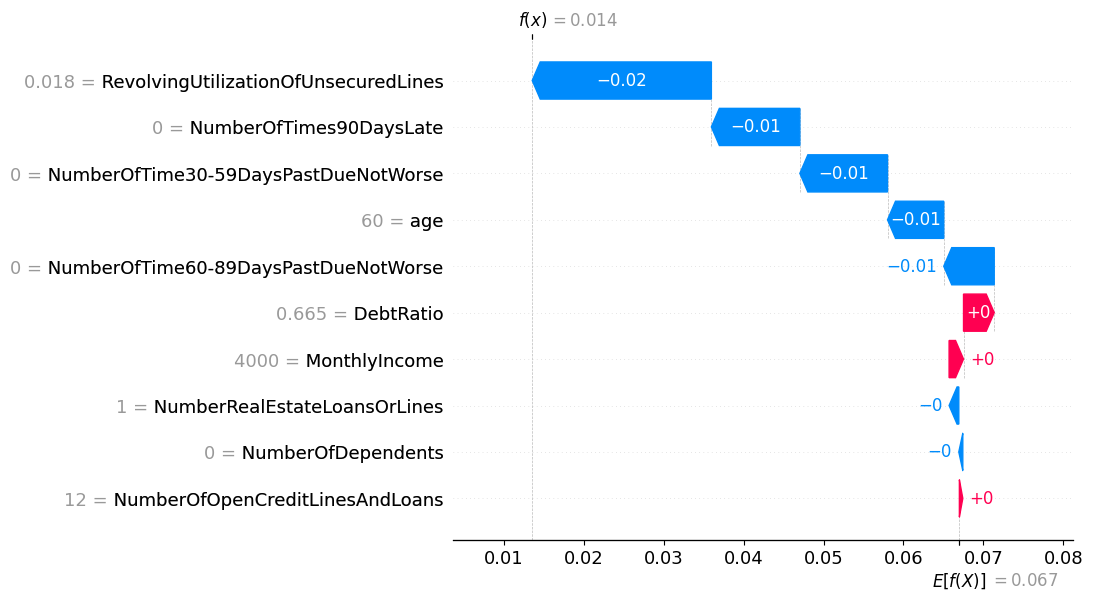

In [72]:
shap.plots.waterfall(exp[:,:,1][49693])

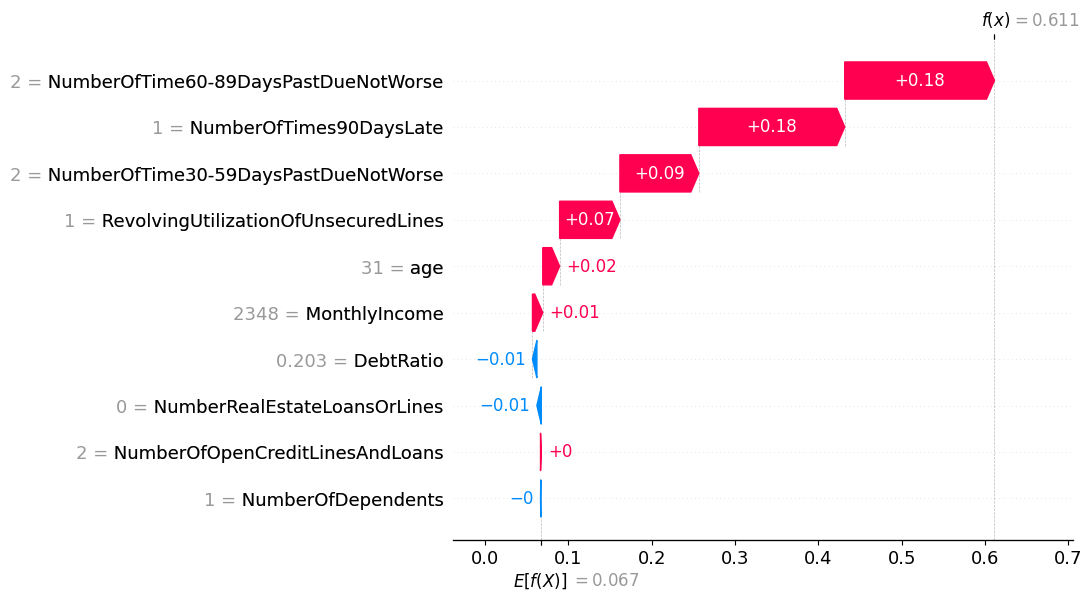

In [73]:
shap.plots.waterfall(exp[:,:,1][19289])

In [74]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[:,:,1][49693], train.loc[49693])

In [75]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[:,:,1][19289], train.loc[19289])

#### SHAP dependence plots

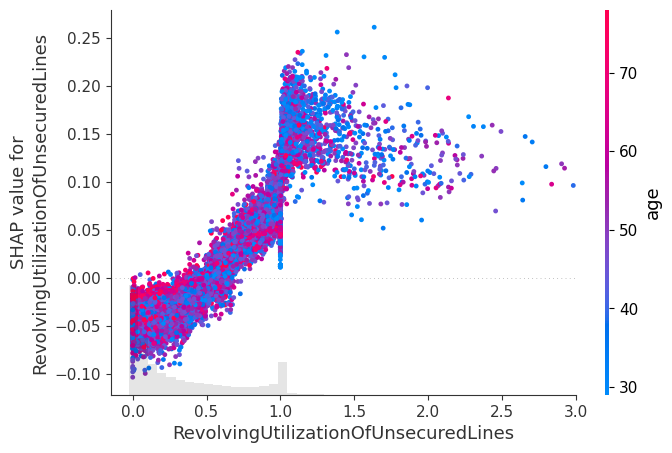

In [76]:
shap.plots.scatter(exp[:,'RevolvingUtilizationOfUnsecuredLines',1], ylabel="SHAP value\n(higher means more likely to default)", color=exp[:,'age',1], xmax = 3, dot_size=12)



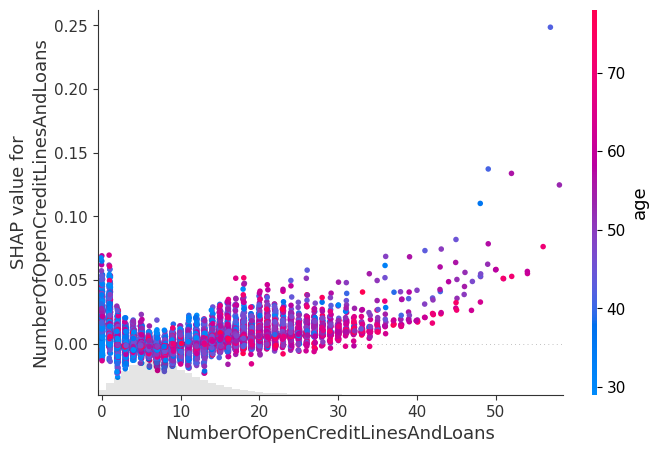

In [77]:
shap.plots.scatter(exp[:,'NumberOfOpenCreditLinesAndLoans',1], ylabel="SHAP value\n(higher means more likely to default)", color=exp[:,'age',1], xmax = 100)

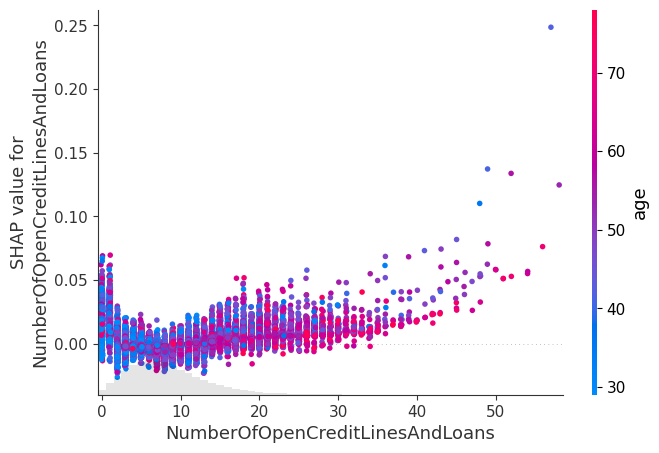

In [78]:
shap.plots.scatter(exp[:,'NumberOfOpenCreditLinesAndLoans',1], ylabel="SHAP value\n(higher means more likely to default)", color=exp[:,'age',1], xmax = 20)

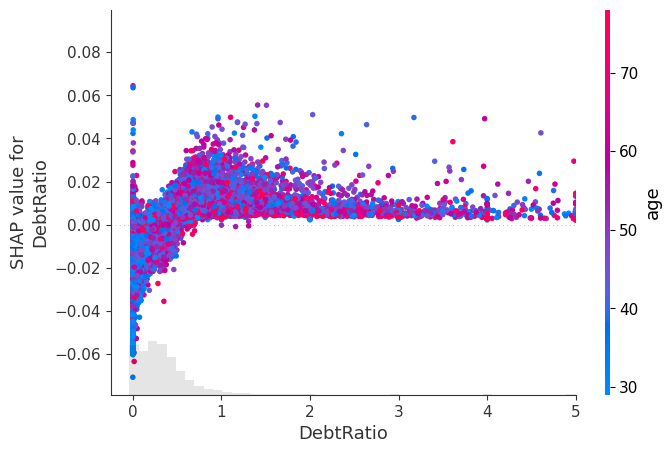

In [79]:
shap.plots.scatter(exp[:,'DebtRatio',1], ylabel="SHAP value\n(higher means more likely to default)", color=exp[:,'age',1], xmax = 5)

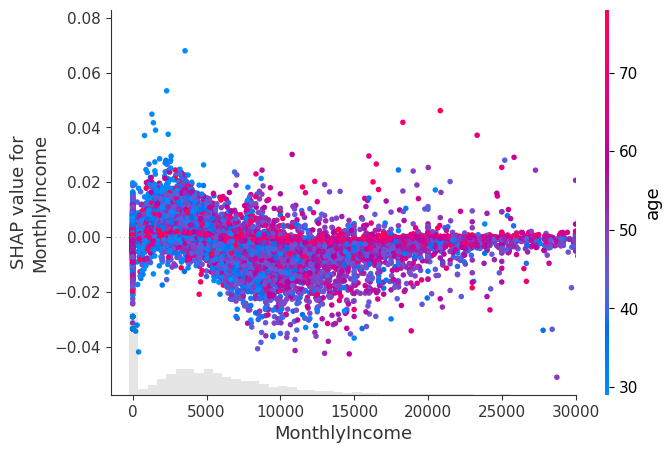

In [80]:
shap.plots.scatter(exp[:,'MonthlyIncome',1], ylabel="SHAP value\n(higher means more likely to default)", color=exp[:,'age',1], xmax = 30000)